# Simulation for Salt intrusion


First the nessecary python packages are imported. This is a combination of open source packages (numpy, pygimli, ..) and code developed by Deltares (ert_inversion)

In [2]:
import numpy as np
import subprocess

import pygimli as pg
from pygimli.meshtools import readGmsh
from pygimli.physics import ert

from ertoolbox import inversion
from ertoolbox import MPT

## Mesh

To be able to simulate for the real geometry of the field measurements, the inversion mesh is created using GMSH and imported using Pygimli. The input file is .geo file and is rewritten into a .msh. After importing the mesh, the prior resistivity values are set in the K value per mesh domain. 

Creating a working mesh is very important, some key aspects that are vital for the inversion to work are:
- mesh should consists of points, lines, line loops and a plane surface, that are also made 'physical'
- line loop should be a closed loop
- electrode positions should be a point defined in the input file
- if you cannot make the mesh in gmsh already, the geometry is corrupt

We use 2 files. 1 file only has 1 fixed conductivity in the inversion domain. The other one has a fresh-salt interface and uses 2 different conductivities. 


The .geo file in imported, translated to .msh and filled with K values in this part of the code:

Reading mesh.msh... 

  Nodes: 578
  Entries: 1252
    Points: 98
    Lines: 150
    Triangles: 1004
    Quads: 0
    Tetrahedra: 0 

Creating mesh object... 

  Dimension: 2-D
  Boundary types: 1 (-1,)
  Regions: 1 (2,)
  Marked nodes: 98 (99,)

Done. 

  Mesh: Nodes: 578 Cells: 1004 Boundaries: 1581


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x26e8ef67410>)

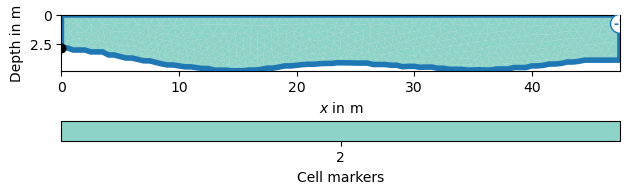

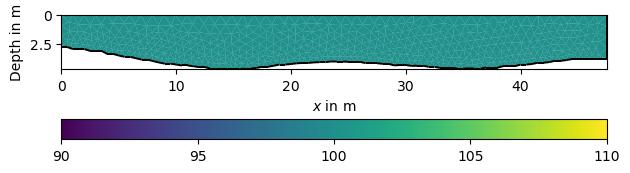

In [27]:
filename_1l = "../data/Salt_intrusion_1_layer.geo"

geom_1l = subprocess.call(["gmsh", "-format", "msh2", "-2", "-o", "mesh.msh", filename_1l], shell=True)
mesh_1l = readGmsh("mesh.msh", verbose=True)
mesh = mesh_1l
K_1l= [[2,100]]

pg.show(mesh_1l, markers=True, clipBoundaryMarkers=True)
pg.show(mesh_1l, data = K_1l, clipBoundaryMarkers=True, showmesh=True)

Reading mesh.msh... 

  Nodes: 517
  Entries: 980
    Points: 98
    Lines: 0
    Triangles: 882
    Quads: 0
    Tetrahedra: 0 

Creating mesh object... 

  Dimension: 2-D
  Regions: 2 (2, 3)
  Marked nodes: 98 (120,)

Done. 

  Mesh: Nodes: 517 Cells: 882 Boundaries: 1398
	ID: 98, Marker: 0	RVector3: (41.2, -3.2, 0.0)



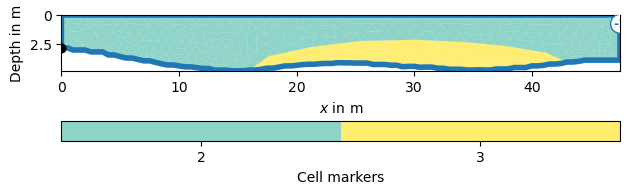

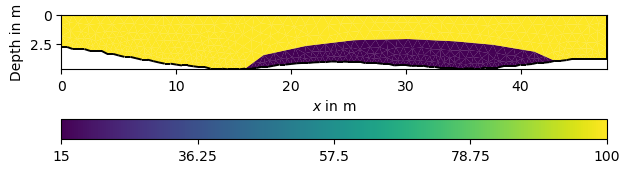

In [28]:
filename_2l = "../data/Salt_intrusion_2_layers.geo"
geom_2l = subprocess.call(["gmsh", "-format", "msh2", "-2", "-o", "mesh.msh", filename_2l], shell=True)
mesh_2l = readGmsh("mesh.msh", verbose=True)

K_2l= [[2,100],[3,15]]

pg.show(mesh_2l, markers=True, clipBoundaryMarkers=True)
pg.show(mesh_2l, data = K_2l, clipBoundaryMarkers=True, showmesh=True)

print(mesh_2l.nodes()[98])

for the inversion, we use a clean mesh.

In [29]:
filename = "../data/Salt_intrusion_1_layer.geo"
geom = subprocess.call(["gmsh", "-format", "msh2", "-2", "-o", "mesh.msh", filename])
mesh = readGmsh("mesh.msh", verbose=True)

pg.show(mesh, markers=True, clipBoundaryMarkers=True)
pg.show(mesh,clipBoundaryMarkers=True, showmesh=True)

FileNotFoundError: [WinError 2] The system cannot find the file specified

## Simulate data

Using the custom mesh, we can make simulation data. This consists of the electrode positions and the inversion scheme. 3 schemes are shown here: dipole-dipole (dd), multiple gradient(gr) and one costom made mesh that was used in the field test.

Other possible standard configurations are: 
Wenner Alpha (C-P-P-C) :  wa
Wenner Beta(C-C-P-P) :  wb
Dipole Dipole (CC-PP) :  dd
Schlumberger(C-PP-C) :  slm
Pole Pole (C-P) :  pp
Pole Dipole (C-PP) :  pd
Half Wenner (C-P-P) :  hw
MultipleGradient(C--P-P--C) :  gr


first, the electrode positions are defined:

In [4]:
EX = np.array([0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00,5.50,6.00,6.50,7.00,7.50,8.00,8.50,9.00,9.50,10.00,10.50,11.00,11.50,12.00,12.50,13.00,13.50,14.00,14.50,15.00,15.50,16.00,16.50,17.00,17.50,18.00,18.50,19.00,19.50,20.00,20.50,21.00,21.50,22.00,22.50,23.00,23.50,24.00,24.50,25.00,25.50,26.00,26.50,27.00,27.50,28.00,28.50,29.00,29.50,30.00,30.50,31.00,31.50,32.00,32.50,33.00,33.50,34.00,34.50,35.00,35.50,36.00,36.50,37.00,37.50,38.00,38.50,39.00,39.50,40.00,40.50,41.00,41.50,42.00,42.50,43.00,43.50,44.00,44.50,45.00,45.50,46.00,46.50,47.00])
EZ = np.array([-2.80,-2.98,-2.98,-2.98,-3.14,-3.14,-3.14,-3.40,-3.40,-3.54,-3.66,-3.66,-3.78,-3.90,-3.90,-4.03,-4.15,-4.25,-4.25,-4.33,-4.41,-4.41,-4.48,-4.55,-4.55,-4.69,-4.69,-4.69,-4.74,-4.74,-4.74,-4.68,-4.68,-4.62,-4.52,-4.52,-4.43,-4.33,-4.33,-4.28,-4.22,-4.19,-4.19,-4.14,-4.12,-4.12,-4.06,-4.07,-4.07,-4.09,-4.09,-4.09,-4.21,-4.21,-4.21,-4.27,-4.27,-4.40,-4.37,-4.37,-4.45,-4.43,-4.43,-4.53,-4.53,-4.62,-4.62,-4.62,-4.68,-4.68,-4.66,-4.68,-4.68,-4.59,-4.59,-4.59,-4.47,-4.47,-4.47,-4.33,-4.33,-4.28,-4.17,-4.17,-4.12,-4.00,-4.00,-3.94,-3.84,-3.84,-3.84,-3.84,-3.84,-3.84])

electrodes = [[x, y] for x, y in zip(EX, EZ)]
print(electrodes)

[[0.5, -2.8], [1.0, -2.98], [1.5, -2.98], [2.0, -2.98], [2.5, -3.14], [3.0, -3.14], [3.5, -3.14], [4.0, -3.4], [4.5, -3.4], [5.0, -3.54], [5.5, -3.66], [6.0, -3.66], [6.5, -3.78], [7.0, -3.9], [7.5, -3.9], [8.0, -4.03], [8.5, -4.15], [9.0, -4.25], [9.5, -4.25], [10.0, -4.33], [10.5, -4.41], [11.0, -4.41], [11.5, -4.48], [12.0, -4.55], [12.5, -4.55], [13.0, -4.69], [13.5, -4.69], [14.0, -4.69], [14.5, -4.74], [15.0, -4.74], [15.5, -4.74], [16.0, -4.68], [16.5, -4.68], [17.0, -4.62], [17.5, -4.52], [18.0, -4.52], [18.5, -4.43], [19.0, -4.33], [19.5, -4.33], [20.0, -4.28], [20.5, -4.22], [21.0, -4.19], [21.5, -4.19], [22.0, -4.14], [22.5, -4.12], [23.0, -4.12], [23.5, -4.06], [24.0, -4.07], [24.5, -4.07], [25.0, -4.09], [25.5, -4.09], [26.0, -4.09], [26.5, -4.21], [27.0, -4.21], [27.5, -4.21], [28.0, -4.27], [28.5, -4.27], [29.0, -4.4], [29.5, -4.37], [30.0, -4.37], [30.5, -4.45], [31.0, -4.43], [31.5, -4.43], [32.0, -4.53], [32.5, -4.53], [33.0, -4.62], [33.5, -4.62], [34.0, -4.62], [34.

### Dipole Dipole

The scheme is built-in and data is created using the dipole-dipole scheme for both geometries. Next, the simulated data is inverted using a clean inversion mesh.

16/09/24 - 13:53:41 - pyGIMLi - INFO - Data error estimate (min:max)  0.01000005691882395 : 0.32746031746031745


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


16/09/24 - 13:53:42 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000061565813899 : 0.5321547755851762
16/09/24 - 13:53:42 - pyGIMLi - INFO - Found 1 regions.
16/09/24 - 13:53:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/09/24 - 13:53:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/09/24 - 13:53:42 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2159 Cells: 4016 Boundaries: 3162
16/09/24 - 13:53:43 - pyGIMLi - INFO - Use median(data values)=101.81889305370092
16/09/24 - 13:53:43 - pyGIMLi - INFO - Created startmodel from forward operator: 1004, min/max=101.818893/101.818893
16/09/24 - 13:53:43 - pyGIMLi - INFO - Starting inversion.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000026E8FC66250>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000026E8CF38A90>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000026E8CF39DF0>
min/max (data): 0.41/176
min/max (error): 1%/32.75%
min/max (start model): 102/102
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   13.86
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    7.78 (dPhi = 42.68%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.41 (dPhi = 26.91%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    4.96 (dPhi = 3.94%) lam: 20.0
----------------------------------------------------

16/09/24 - 13:54:28 - pyGIMLi - INFO - Found 1 regions.
16/09/24 - 13:54:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/09/24 - 13:54:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


chi² =    4.95 (dPhi = 0.01%) lam: 20.0
################################################################################
#                Abort criterion reached: dPhi = 0.01 (< 2.0%)                 #
################################################################################


16/09/24 - 13:54:28 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2159 Cells: 4016 Boundaries: 3162
16/09/24 - 13:54:28 - pyGIMLi - INFO - Use median(data values)=34.73855116724736
16/09/24 - 13:54:28 - pyGIMLi - INFO - Created startmodel from forward operator: 1004, min/max=34.738551/34.738551
16/09/24 - 13:54:28 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000026E8CE8F7E0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000026E8EF91670>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000026E8CE858F0>
min/max (data): 0.79/290
min/max (error): 1%/45.96%
min/max (start model): 34.74/34.74
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 3631.30
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  741.66 (dPhi = 79.53%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  217.35 (dPhi = 70.58%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   93.26 (dPhi = 56.62%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =   46.71 (dPhi = 49.13%) lam: 20.0
-----------

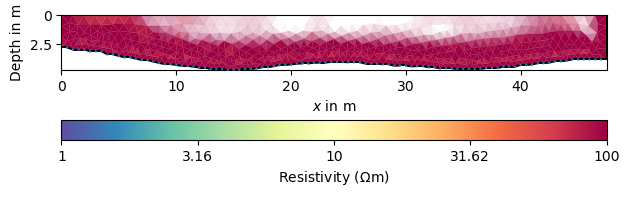

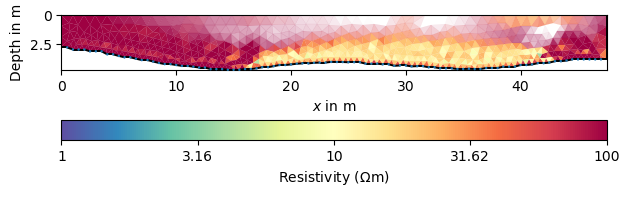

In [31]:
scheme_dd = ert.createData(elecs=electrodes, schemeName='dd')

simdata_dd_1l = ert.simulate(
         mesh=mesh_1l, scheme=scheme_dd, res=K_1l, noiseLevel=1, noiseAbs=1e-6, seed=1337
    )

simdata_dd_2l = ert.simulate(
         mesh=mesh_2l, scheme=scheme_dd, res=K_2l, noiseLevel=1, noiseAbs=1e-6, seed=1337
    )

simdata_dd_1l.remove(simdata_dd_1l['rhoa'] < 0)
simdata_dd_2l.remove(simdata_dd_2l['rhoa'] < 0)

inversion_dd_1 = inversion(simdata_dd_1l, mesh, saveresult=False)

inversion_dd_2 = inversion(simdata_dd_2l, mesh, saveresult=False)



### Gradient
for the gradient based scheme, the workflow is the same as for dipole dipole.

In [ ]:
scheme_gr = ert.createData(elecs=electrodes, schemeName = 'gr')

simdata_gr_1l = ert.simulate(mesh=mesh_1l, scheme=scheme_gr, res=K_1l, noiseLevel=1, noiseAbs=1e-6, seed=1337)
simdata_gr_2l = ert.simulate(mesh=mesh_2l, scheme=scheme_gr, res=K_2l, noiseLevel=1, noiseAbs=1e-6, seed=1337)

simdata_gr_1l.remove(simdata_gr_1l['rhoa'] < 0)
simdata_gr_2l.remove(simdata_gr_2l['rhoa'] < 0)

inversion_gr_1 = inversion(simdata_gr_1l, mesh, saveresult=False)

inversion_gr_2 = inversion(simdata_gr_2l, mesh, saveresult=False)

: 

### Customized

For the customized scheme, this scheme should be created first and written down in a datacontainer for Pygimli to be able to handle the scheme.

In [ ]:
#datacontainer for custom abmn

import pygimli as pg
from pygimli.physics import ert
def prepare_custom_scheme(EX,EZ):
    dc = pg.DataContainerERT()

    for s in range(len(EX)):
        dc.createSensor(
            [
                EX[s],
                0,
                EZ[s],
            ]
        )
    
    A = [2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,61,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,68,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,78,78,78,78,78,78,78,78,78,78,78,78,78,78,79,79,79,79,79,79,79,79,79,79,79,79,79,80,80,80,80,80,80,80,80,80,80,80,80,80,81,81,81,81,81,81,81,81,81,81,81,81,81,82,82,82,82,82,82,82,82,82,82,82,82,83,83,83,83,83,83,83,83,83,83,83,84,84,84,84,84,84,84,84,84,84,85,85,85,85,85,85,85,85,85,86,86,86,86,86,86,86,86,87,87,87,87,87,87,87,88,88,88,88,88,88,88,89,89,89,89,89,89,90,90,90,90,90,91,91,91,91,92,92,92,93,93,94
]
    B = [1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,4,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,5,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,6,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7,7,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7,8,8,8,8,8,8,8,6,6,6,6,6,6,7,7,7,7,7,7,8,8,8,8,8,8,9,9,9,9,9,9,9,7,7,7,7,7,7,8,8,8,8,8,8,9,9,9,9,9,9,10,10,10,10,10,10,10,8,8,8,8,8,8,9,9,9,9,9,9,10,10,10,10,10,10,11,11,11,11,11,11,11,9,9,9,9,9,9,10,10,10,10,10,10,11,11,11,11,11,11,12,12,12,12,12,12,12,10,10,10,10,10,10,11,11,11,11,11,11,12,12,12,12,12,12,13,13,13,13,13,13,13,11,11,11,11,11,11,12,12,12,12,12,12,13,13,13,13,13,13,14,14,14,14,14,14,14,12,12,12,12,12,12,13,13,13,13,13,13,14,14,14,14,14,14,15,15,15,15,15,15,15,13,13,13,13,13,13,14,14,14,14,14,14,15,15,15,15,15,15,16,16,16,16,16,16,16,14,14,14,14,14,14,15,15,15,15,15,15,16,16,16,16,16,16,17,17,17,17,17,17,17,15,15,15,15,15,15,16,16,16,16,16,16,17,17,17,17,17,17,18,18,18,18,18,18,18,16,16,16,16,16,16,17,17,17,17,17,17,18,18,18,18,18,18,19,19,19,19,19,19,19,17,17,17,17,17,17,18,18,18,18,18,18,19,19,19,19,19,19,20,20,20,20,20,20,20,18,18,18,18,18,18,19,19,19,19,19,19,20,20,20,20,20,20,21,21,21,21,21,21,21,19,19,19,19,19,19,20,20,20,20,20,20,21,21,21,21,21,21,22,22,22,22,22,22,22,20,20,20,20,20,20,21,21,21,21,21,21,22,22,22,22,22,22,23,23,23,23,23,23,23,21,21,21,21,21,21,22,22,22,22,22,22,23,23,23,23,23,23,24,24,24,24,24,24,24,22,22,22,22,22,22,23,23,23,23,23,23,24,24,24,24,24,24,25,25,25,25,25,25,25,23,23,23,23,23,23,24,24,24,24,24,24,25,25,25,25,25,25,26,26,26,26,26,26,26,24,24,24,24,24,24,25,25,25,25,25,25,26,26,26,26,26,26,27,27,27,27,27,27,27,25,25,25,25,25,25,26,26,26,26,26,26,27,27,27,27,27,27,28,28,28,28,28,28,28,26,26,26,26,26,26,27,27,27,27,27,27,28,28,28,28,28,28,29,29,29,29,29,29,29,27,27,27,27,27,27,28,28,28,28,28,28,29,29,29,29,29,29,30,30,30,30,30,30,30,28,28,28,28,28,28,29,29,29,29,29,29,30,30,30,30,30,30,31,31,31,31,31,31,31,29,29,29,29,29,29,30,30,30,30,30,30,31,31,31,31,31,31,32,32,32,32,32,32,32,30,30,30,30,30,30,31,31,31,31,31,31,32,32,32,32,32,32,33,33,33,33,33,33,33,31,31,31,31,31,31,32,32,32,32,32,32,33,33,33,33,33,33,34,34,34,34,34,34,34,32,32,32,32,32,32,33,33,33,33,33,33,34,34,34,34,34,34,35,35,35,35,35,35,35,33,33,33,33,33,33,34,34,34,34,34,34,35,35,35,35,35,35,36,36,36,36,36,36,36,34,34,34,34,34,34,35,35,35,35,35,35,36,36,36,36,36,36,37,37,37,37,37,37,37,35,35,35,35,35,35,36,36,36,36,36,36,37,37,37,37,37,37,38,38,38,38,38,38,38,36,36,36,36,36,36,37,37,37,37,37,37,38,38,38,38,38,38,39,39,39,39,39,39,39,37,37,37,37,37,37,38,38,38,38,38,38,39,39,39,39,39,39,40,40,40,40,40,40,40,38,38,38,38,38,38,39,39,39,39,39,39,40,40,40,40,40,40,41,41,41,41,41,41,41,39,39,39,39,39,39,40,40,40,40,40,40,41,41,41,41,41,41,42,42,42,42,42,42,42,40,40,40,40,40,40,41,41,41,41,41,41,42,42,42,42,42,42,43,43,43,43,43,43,43,41,41,41,41,41,41,42,42,42,42,42,42,43,43,43,43,43,43,44,44,44,44,44,44,44,42,42,42,42,42,42,43,43,43,43,43,43,44,44,44,44,44,44,45,45,45,45,45,45,45,43,43,43,43,43,43,44,44,44,44,44,44,45,45,45,45,45,45,46,46,46,46,46,46,46,44,44,44,44,44,44,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47,47,47,47,47,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47,47,47,47,48,48,48,48,48,48,48,46,46,46,46,46,46,47,47,47,47,47,47,48,48,48,48,48,48,49,49,49,49,49,49,49,47,47,47,47,47,47,48,48,48,48,48,48,49,49,49,49,49,49,50,50,50,50,50,50,50,48,48,48,48,48,48,49,49,49,49,49,49,50,50,50,50,50,50,51,51,51,51,51,51,51,49,49,49,49,49,49,50,50,50,50,50,50,51,51,51,51,51,51,52,52,52,52,52,52,52,50,50,50,50,50,50,51,51,51,51,51,51,52,52,52,52,52,52,53,53,53,53,53,53,53,51,51,51,51,51,51,52,52,52,52,52,52,53,53,53,53,53,53,54,54,54,54,54,54,54,52,52,52,52,52,52,53,53,53,53,53,53,54,54,54,54,54,54,55,55,55,55,55,55,55,53,53,53,53,53,53,54,54,54,54,54,54,55,55,55,55,55,55,56,56,56,56,56,56,56,54,54,54,54,54,54,55,55,55,55,55,55,56,56,56,56,56,56,57,57,57,57,57,57,57,55,55,55,55,55,55,56,56,56,56,56,56,57,57,57,57,57,57,58,58,58,58,58,58,58,56,56,56,56,56,56,57,57,57,57,57,57,58,58,58,58,58,58,59,59,59,59,59,59,59,57,57,57,57,57,57,58,58,58,58,58,58,59,59,59,59,59,59,60,60,60,60,60,60,60,58,58,58,58,58,58,59,59,59,59,59,59,60,60,60,60,60,60,61,61,61,61,61,61,61,59,59,59,59,59,59,60,60,60,60,60,60,61,61,61,61,61,61,62,62,62,62,62,62,62,60,60,60,60,60,60,61,61,61,61,61,61,62,62,62,62,62,62,63,63,63,63,63,63,63,61,61,61,61,61,61,62,62,62,62,62,62,63,63,63,63,63,63,64,64,64,64,64,64,64,62,62,62,62,62,63,63,63,63,63,63,64,64,64,64,64,64,65,65,65,65,65,65,65,63,63,63,63,64,64,64,64,64,64,65,65,65,65,65,65,66,66,66,66,66,66,66,64,64,64,65,65,65,65,65,65,66,66,66,66,66,66,67,67,67,67,67,67,67,65,65,66,66,66,66,66,66,67,67,67,67,67,67,68,68,68,68,68,68,68,66,67,67,67,67,67,67,68,68,68,68,68,68,69,69,69,69,69,69,69,68,68,68,68,68,68,69,69,69,69,69,69,70,70,70,70,70,70,70,69,69,69,69,69,69,70,70,70,70,70,70,71,71,71,71,71,71,71,70,70,70,70,70,70,71,71,71,71,71,71,72,72,72,72,72,72,72,71,71,71,71,71,72,72,72,72,72,72,73,73,73,73,73,73,73,72,72,72,72,73,73,73,73,73,73,74,74,74,74,74,74,74,73,73,73,74,74,74,74,74,74,75,75,75,75,75,75,75,74,74,75,75,75,75,75,75,76,76,76,76,76,76,76,75,76,76,76,76,76,76,77,77,77,77,77,77,77,77,77,77,77,77,77,78,78,78,78,78,78,78,78,78,78,78,78,78,79,79,79,79,79,79,79,79,79,79,79,79,79,80,80,80,80,80,80,80,80,80,80,80,80,81,81,81,81,81,81,81,81,81,81,81,82,82,82,82,82,82,82,82,82,82,83,83,83,83,83,83,83,83,83,84,84,84,84,84,84,84,84,85,85,85,85,85,85,85,86,86,86,86,86,86,86,87,87,87,87,87,87,87,88,88,88,88,88,88,89,89,89,89,89,90,90,90,90,91,91,91,92,92,93
]
    M = [3,4,5,6,7,8,9,11,12,13,14,15,16,4,5,6,7,8,9,10,19,20,21,22,23,24,12,13,14,15,16,17,5,6,7,8,9,10,11,27,28,29,30,31,32,20,21,22,23,24,25,13,14,15,16,17,18,6,7,8,9,10,11,12,28,29,30,31,32,33,21,22,23,24,25,26,14,15,16,17,18,19,7,8,9,10,11,12,13,29,30,31,32,33,34,22,23,24,25,26,27,15,16,17,18,19,20,8,9,10,11,12,13,14,30,31,32,33,34,35,23,24,25,26,27,28,16,17,18,19,20,21,9,10,11,12,13,14,15,31,32,33,34,35,36,24,25,26,27,28,29,17,18,19,20,21,22,10,11,12,13,14,15,16,32,33,34,35,36,37,25,26,27,28,29,30,18,19,20,21,22,23,11,12,13,14,15,16,17,33,34,35,36,37,38,26,27,28,29,30,31,19,20,21,22,23,24,1,1,1,1,1,1,1,34,35,36,37,38,39,27,28,29,30,31,32,2,2,2,2,2,2,1,1,1,1,1,1,1,35,36,37,38,39,40,2,2,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,2,3,3,3,3,4,4,2,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,2,2,3,3,3,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,2,2,2,3,3,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,2,2,2,2,3,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,3,1,1,2,2,2,2,2,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,3,3,1,2,2,2,2,2,2,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,3,3,3,2,2,2,2,2,2,2,4,4,4,4,4,4,3,3,3,3,3,4,2,2,3,3,3,3,2,2,2,2,2,2,2,4,4,4,4,4,4,3,3,3,3,4,4,2,3,3,3,3,3,2,2,2,2,2,2,2,4,4,4,4,4,4,3,3,3,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,4,4,4,4,4,5,3,3,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,3,4,4,4,4,5,5,3,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,3,3,4,4,4,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,3,3,3,4,4,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,3,3,3,3,4,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,4,2,2,3,3,3,3,3,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,4,4,2,3,3,3,3,3,3,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,4,4,4,3,3,3,3,3,3,3,5,5,5,5,5,5,4,4,4,4,4,5,3,3,4,4,4,4,3,3,3,3,3,3,3,5,5,5,5,5,5,4,4,4,4,5,5,3,4,4,4,4,4,3,3,3,3,3,3,3,5,5,5,5,5,5,4,4,4,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,3,5,5,5,5,5,6,4,4,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,4,5,5,5,5,6,6,4,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,4,4,5,5,5,6,6,6,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,4,4,4,5,5,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,4,4,4,4,5,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,5,3,3,4,4,4,4,4,6,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,5,5,3,4,4,4,4,4,4,6,6,6,6,6,6,5,5,5,5,5,5,4,4,4,5,5,5,4,4,4,4,4,4,4,6,6,6,6,6,6,5,5,5,5,5,6,4,4,5,5,5,5,4,4,4,4,4,4,4,6,6,6,6,6,6,5,5,5,5,6,6,4,5,5,5,5,5,4,4,4,4,4,4,4,6,6,6,6,6,6,5,5,5,6,6,6,5,5,5,5,5,5,4,4,4,4,4,4,4,6,6,6,6,6,7,5,5,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,4,5,6,6,6,6,7,7,5,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,5,5,6,6,6,7,7,7,6,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,5,5,5,6,6,7,7,7,7,6,6,6,6,6,6,5,5,5,5,5,5,4,4,4,5,5,5,5,6,7,7,7,7,7,6,6,6,6,6,6,5,5,5,5,5,6,4,4,5,5,5,5,5,7,7,7,7,7,7,6,6,6,6,6,6,5,5,5,5,6,6,4,5,5,5,5,5,5,7,7,7,7,7,7,6,6,6,6,6,6,5,5,5,6,6,6,5,5,5,5,5,5,5,7,7,7,7,7,7,6,6,6,6,6,7,5,5,6,6,6,6,5,5,5,5,5,5,5,7,7,7,7,7,7,6,6,6,6,7,7,5,6,6,6,6,6,5,5,5,5,5,5,5,7,7,7,7,7,7,6,6,6,7,7,7,6,6,6,6,6,6,5,5,5,5,5,5,5,7,7,7,7,7,8,6,6,7,7,7,7,6,6,6,6,6,6,5,5,5,5,5,5,6,7,7,7,7,8,8,6,7,7,7,7,7,6,6,6,6,6,6,5,5,5,5,5,6,6,7,7,7,8,8,8,7,7,7,7,7,7,6,6,6,6,6,6,5,5,5,5,6,6,6,7,7,8,8,8,8,7,7,7,7,7,7,6,6,6,6,6,6,5,5,5,6,6,6,6,7,8,8,8,8,8,7,7,7,7,7,7,6,6,6,6,6,7,5,5,6,6,6,6,6,8,8,8,8,8,8,7,7,7,7,7,7,6,6,6,6,7,7,5,6,6,6,6,6,6,8,8,8,8,8,8,7,7,7,7,7,7,6,6,6,7,7,7,6,6,6,6,6,6,6,8,8,8,8,8,8,7,7,7,7,7,8,6,6,7,7,7,7,6,6,6,6,6,6,6,8,8,8,8,8,8,7,7,7,7,8,8,6,7,7,7,7,7,6,6,6,6,6,6,6,8,8,8,8,8,8,7,7,7,8,8,8,7,7,7,7,7,7,6,6,6,6,6,6,6,8,8,8,8,8,9,7,7,8,8,8,8,7,7,7,7,7,7,6,6,6,6,6,6,7,8,8,8,8,9,9,7,8,8,8,8,8,7,7,7,7,7,7,6,6,6,6,6,7,7,8,8,8,9,9,9,8,8,8,8,8,8,7,7,7,7,7,7,6,6,6,6,7,7,7,8,8,9,9,9,8,8,8,8,8,8,7,7,7,7,7,7,6,6,6,7,7,7,7,8,9,9,9,8,8,8,8,8,8,7,7,7,7,7,8,6,6,7,7,7,7,7,9,9,9,8,8,8,8,8,8,7,7,7,7,8,8,6,7,7,7,7,7,7,9,9,8,8,8,8,8,8,7,7,7,8,8,8,7,7,7,7,7,7,7,9,8,8,8,8,8,9,7,7,8,8,8,8,7,7,7,7,7,7,7,8,8,8,8,9,9,7,8,8,8,8,8,7,7,7,7,7,7,7,8,8,8,9,9,9,8,8,8,8,8,8,7,7,7,7,7,7,7,8,8,9,9,9,9,8,8,8,8,8,8,7,7,7,7,7,7,8,8,9,9,9,9,8,8,8,8,8,8,7,7,7,7,7,8,8,9,9,9,9,8,8,8,8,8,8,7,7,7,7,8,8,8,9,9,9,8,8,8,8,8,8,7,7,7,8,8,8,8,9,9,8,8,8,8,8,9,7,7,8,8,8,8,8,9,8,8,8,8,9,9,7,8,8,8,8,8,8,8,8,8,9,9,9,8,8,8,8,8,8,8,8,8,9,9,9,9,8,8,8,8,8,8,8,8,9,9,9,9,9,8,8,8,8,8,8,8,9,9,9,9,9,8,8,8,8,8,8,8,9,9,9,9,8,8,8,8,8,8,9,9,9,9,8,8,8,8,8,9,9,9,9,8,8,8,8,9,9,9,9,8,8,8,9,9,9,9,8,8,9,9,9,9,9,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
]
    N = [4,5,6,7,8,9,10,13,14,15,16,17,18,5,6,7,8,9,10,11,22,23,24,25,26,27,14,15,16,17,18,19,6,7,8,9,10,11,12,30,31,32,33,34,35,23,24,25,26,27,28,15,16,17,18,19,20,7,8,9,10,11,12,13,31,32,33,34,35,36,24,25,26,27,28,29,16,17,18,19,20,21,8,9,10,11,12,13,14,32,33,34,35,36,37,25,26,27,28,29,30,17,18,19,20,21,22,9,10,11,12,13,14,15,33,34,35,36,37,38,26,27,28,29,30,31,18,19,20,21,22,23,10,11,12,13,14,15,16,34,35,36,37,38,39,27,28,29,30,31,32,19,20,21,22,23,24,11,12,13,14,15,16,17,3,3,3,3,3,4,2,2,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,3,3,3,3,4,4,2,3,3,3,3,3,2,2,2,2,2,2,2,3,4,5,6,7,8,3,3,3,4,4,4,3,3,3,3,3,3,0,1,2,3,4,5,3,4,5,6,7,8,9,3,3,4,4,4,4,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,5,6,7,8,9,0,1,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,6,7,8,9,0,1,2,8,9,0,1,2,1,2,3,4,5,6,4,5,6,7,8,9,7,8,9,0,1,2,3,9,0,1,2,2,3,4,5,6,7,5,6,7,8,9,0,8,9,0,1,2,3,4,0,1,2,3,4,5,6,7,8,6,7,8,9,0,1,9,0,1,2,3,4,5,1,2,4,5,6,7,8,9,7,8,9,0,1,2,0,1,2,3,4,5,6,2,5,6,7,8,9,0,8,9,0,1,2,3,1,2,3,4,5,6,7,6,7,8,9,0,1,9,0,1,2,3,4,2,3,4,5,6,7,8,7,8,9,0,1,2,0,1,2,3,4,5,3,4,5,6,7,8,9,8,9,0,1,2,3,1,2,3,4,5,6,4,5,6,7,8,9,0,9,0,1,2,3,2,3,4,5,6,7,5,6,7,8,9,0,1,0,1,2,3,3,4,5,6,7,8,6,7,8,9,0,1,2,1,2,3,4,5,6,7,8,9,7,8,9,0,1,2,3,2,3,5,6,7,8,9,0,8,9,0,1,2,3,4,3,6,7,8,9,0,1,9,0,1,2,3,4,5,7,8,9,0,1,2,0,1,2,3,4,5,6,8,9,0,1,2,3,1,2,3,4,5,6,7,9,0,1,2,3,4,2,3,4,5,6,7,8,0,1,2,3,4,3,4,5,6,7,8,9,1,2,3,4,4,5,6,7,8,9,0,2,3,4,5,6,7,8,9,0,1,3,4,6,7,8,9,0,1,2,4,7,8,9,0,1,2,3,8,9,0,1,2,3,4,9,0,1,2,3,4,5,0,1,2,3,4,5,1,2,3,4,5,2,3,4,5,3,4,5,4,5,5
]
    
    for i in range(len(A)):
        dc.addFourPointData(
            A[i]-1,
            B[i]-1,
            M[i]-1,
            N[i]-1,
        )
    k = ert.createGeometricFactors(dc)
    dc.set("k", k)

    return dc

dc = prepare_custom_scheme(EX,EZ)


: 

then, a similar approach of making the data and inverting the data is carried out.

In [ ]:
simdata_c_1l = ert.simulate(mesh=mesh_1l, scheme=dc, res=K_1l, noiseLevel=1, noiseAbs=1e-6, seed=1337)
simdata_c_2l = ert.simulate(mesh=mesh_2l, scheme=dc, res=K_2l, noiseLevel=1, noiseAbs=1e-6, seed=1337)

simdata_c_1l.remove(simdata_c_1l['rhoa'] < 0)
simdata_c_2l.remove(simdata_c_2l['rhoa'] < 0)

inversion_c_1 = inversion(simdata_c_1l, mesh, saveresult=False)
inversion_c_2 = inversion(simdata_c_2l, mesh, saveresult=False)

: 

: 